In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안

목표: 지역별 물류 최적화 방안
주제: 주문부터 배송 완료까지의 시간을 분석해서 물류 취약지역, 원인 확인 필요

배송지연 확률
배송지연이 많이 되는 구간
지역별 배송시간 차이
배송지연 건의 리뷰 점수 / 재시간에 배송된 리뷰점수 비교 (상관관계 분석)

✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.

📊 customers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 geolocation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_items 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_payments 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_reviews 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



📊 products 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



📊 sellers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 product_category_name_translation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전
전체 데이터 행 수: 112,650
IsolationForest 모델이 탐지한 이상치 개수: 1,127
이상치 비율: 1.00%


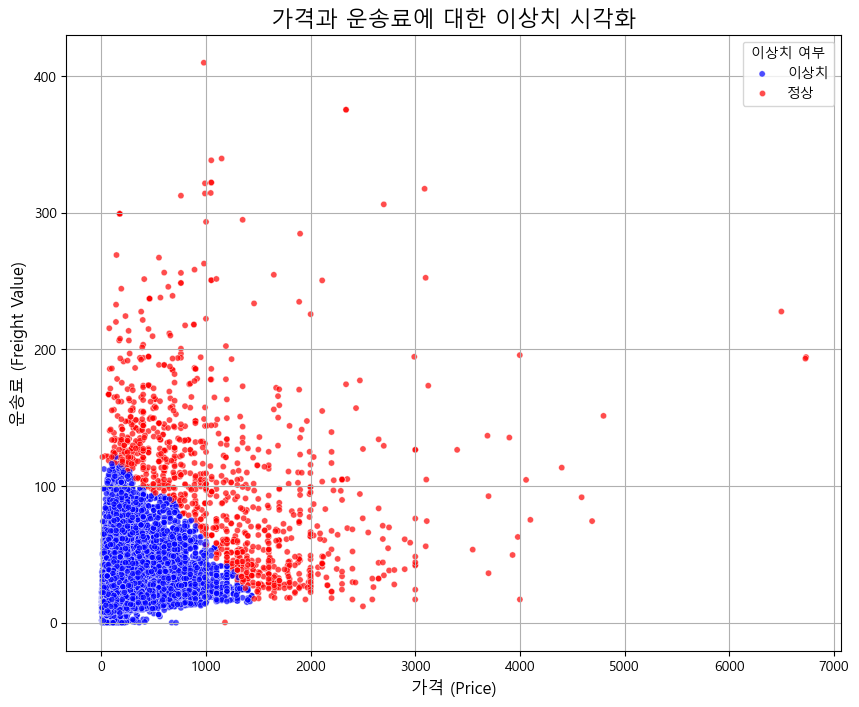

=== 'price' 컬럼 이상치 처리 후 통계량 ===
count    112650.000000
mean        115.296942
std         136.362223
min           9.990000
25%          39.900000
50%          74.990000
75%         134.900000
max         890.000000
Name: price, dtype: float64

=== 'freight_value' 컬럼 이상치 처리 후 통계량 ===
count    112650.000000
mean         19.638178
std          12.816924
min           4.419800
25%          13.080000
50%          16.260000
75%          21.150000
max          84.520000
Name: freight_value, dtype: float64
   review_score  has_comment review_comment_title  \
0             4            0           No Comment   
1             5            0           No Comment   
2             5            0           No Comment   
3             5            1           No Comment   
4             5            1           No Comment   

                              review_comment_message  
0                                         No Comment  
1                                         No Comment  
2          

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
결측값이 있는 행의 데이터 샘플:
                             order_id                       customer_id  \
6    136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44   ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103  0760a852e4e9d

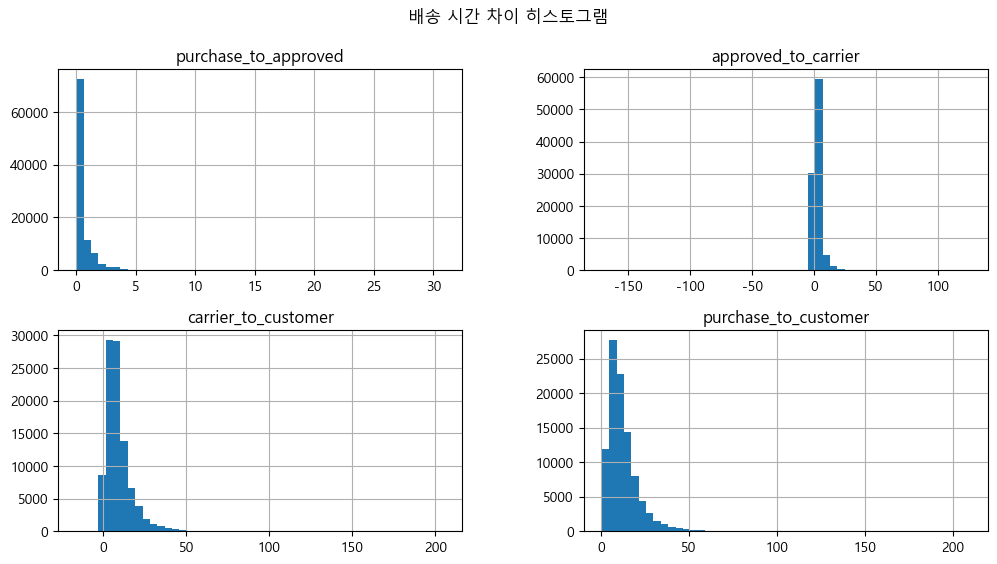

=== Z-score 기준 이상치 비율 (|Z|>3) ===
purchase_to_approved: 2.26%
approved_to_carrier: 1.92%
carrier_to_customer: 1.64%
purchase_to_customer: 1.63%

=== IQR 기준 이상치 비율 ===
purchase_to_approved: 9.26%
approved_to_carrier: 5.80%
carrier_to_customer: 5.26%
purchase_to_customer: 5.08%
이상치 건수: 1373
정제 후 데이터 크기: (95088, 13)


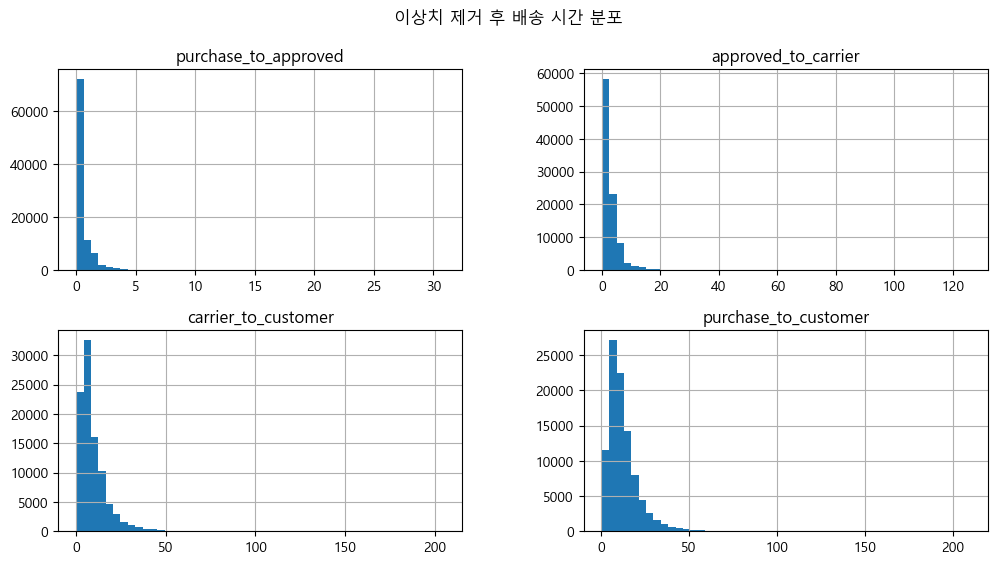

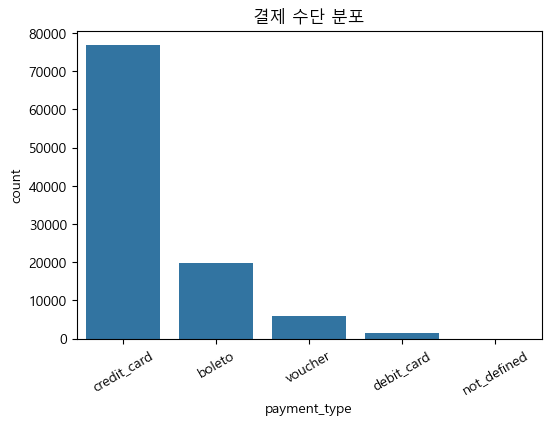


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


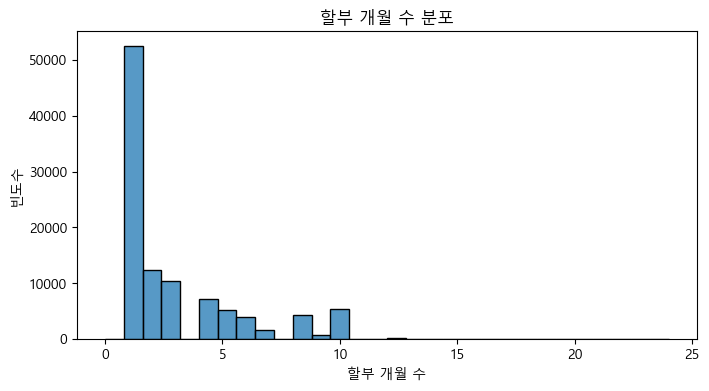


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


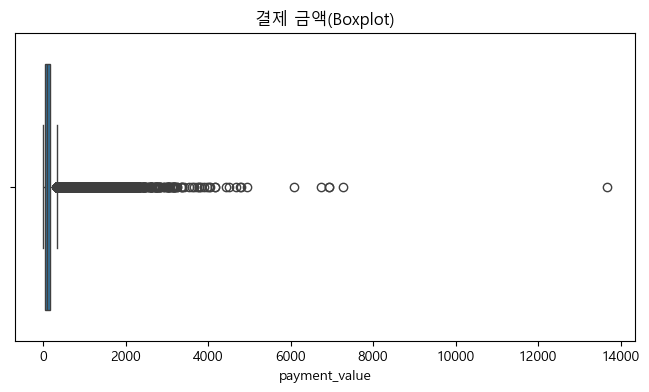

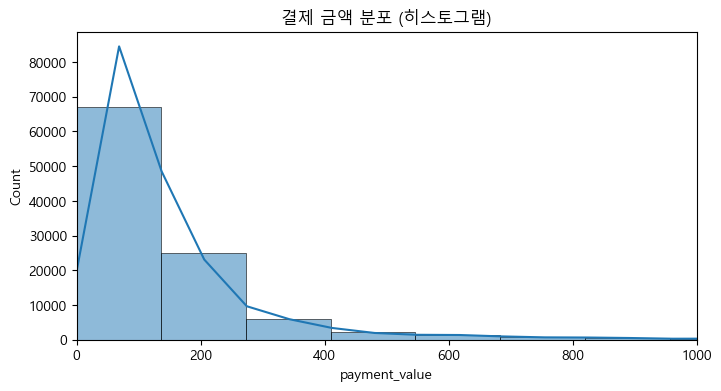


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

[결제 금액 이상치 개수] 7981 / 103886 (7.68%)
installment_label
할부     103884
일시불         2
Name: count, dtype: int64
payment_label
유료결제    103877
0원결제         9
Name: count, dtype: int64
                                order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352         

In [ ]:
from 과제1 import df_sellers, df_order_reviews, merge_ocpi, df_product_category_name_translation

In [5]:
# --- 1) delivered 상태만 필터 ---
df = df_join_ocpi[df_join_ocpi["order_status"]=="delivered"].copy()

# --- 2) 단계별 평균 배송시간 ---
step_cols = ["purchase_to_approved","approved_to_carrier","carrier_to_customer","purchase_to_customer"]
step_mean = df[step_cols].mean().round(2)

print("📌 단계별 평균 배송시간(일 단위)")
print(step_mean)

# --- 3) ETA 대비 지연일 계산 ---
# ETA는 날짜만 저장된 경우가 많아 date 단위 비교 권장
df["delay_days"] = (df["order_delivered_customer_date"].dt.floor("d") - 
                    df["order_estimated_delivery_date"].dt.floor("d")).dt.days

# 정시/지연 여부
df["on_time"] = df["delay_days"] <= 0

# KPI 요약
total = len(df)
on_time = df["on_time"].sum()
late = total - on_time
kpi = {
    "총 배송건수": total,
    "정시배송율": round(on_time/total*100,2),
    "지연배송율": round(late/total*100,2),
    "평균 지연일(지연건만)": round(df.loc[df["delay_days"]>0,"delay_days"].mean(),2)
}
print("\n📌 ETA 대비 KPI")
print(pd.Series(kpi))

# --- 4) 지연 구간 분포 ---
bins = [-np.inf,0,3,7,14,30,np.inf]
labels = ["정시/조기","1-3일 지연","3-7일 지연","7-14일 지연","14-30일 지연","30일 초과"]
delay_dist = pd.cut(df["delay_days"], bins=bins, labels=labels).value_counts(normalize=True).sort_index()
delay_dist = (delay_dist*100).round(2).astype(str) + "%"
print("\n📌 지연 구간 분포")
print(delay_dist)

📌 단계별 평균 배송시간(일 단위)
purchase_to_approved     0.41
approved_to_carrier      2.90
carrier_to_customer      9.24
purchase_to_customer    12.54
dtype: float64

📌 ETA 대비 KPI
총 배송건수          113364.00
정시배송율               93.38
지연배송율                6.62
평균 지연일(지연건만)        10.57
dtype: float64

📌 지연 구간 분포
delay_days
정시/조기        93.38%
1-3일 지연        1.9%
3-7일 지연       1.84%
7-14일 지연      1.47%
14-30일 지연     1.07%
30일 초과        0.34%
Name: proportion, dtype: object


In [6]:
# --- 1) delivered 상태만 필터 ---
df = df_join_order_cp[df_join_order_cp["order_status"]=="delivered"].copy()

# --- 2) ETA 대비 지연일 ---
df["delay_days"] = (df["order_delivered_customer_date"].dt.floor("d") - 
                    df["order_estimated_delivery_date"].dt.floor("d")).dt.days
df["on_time"] = df["delay_days"] <= 0

# --- 3) 지역별 성과 집계 ---
region_metrics = df.groupby("customer_city").agg(
    주문수 = ("order_id","count"),
    평균_승인까지 = ("purchase_to_approved","mean"),
    평균_승인_배송사 = ("approved_to_carrier","mean"),
    평균_배송사_고객 = ("carrier_to_customer","mean"),
    평균_전체배송 = ("purchase_to_customer","mean"),
    정시배송율 = ("on_time","mean"),
    평균_지연일 = ("delay_days", lambda x: x[x>0].mean())
).reset_index()

# 퍼센트 변환
region_metrics["정시배송율"] = (region_metrics["정시배송율"]*100).round(2)
region_metrics = region_metrics.round(2)

# --- 4) 상위/하위 지역 확인 (주문건수 기준 필터링) ---
# 너무 주문수가 적은 지역은 신뢰도가 낮으므로, 예: 50건 이상만
region_metrics_filtered = region_metrics[region_metrics["주문수"] >= 50]

# 정시배송율 Top 10
top10 = region_metrics_filtered.sort_values("정시배송율", ascending=False).head(10)

# 정시배송율 Bottom 10
bottom10 = region_metrics_filtered.sort_values("정시배송율", ascending=True).head(10)

print("\n📌 지역별 배송 성과 (샘플 5행)")
print(region_metrics_filtered.head())

print("\n📌 정시배송율 Top 10 지역")
print(top10[["customer_city","주문수","평균_전체배송","정시배송율","평균_지연일"]])

print("\n📌 정시배송율 Bottom 10 지역")
print(bottom10[["customer_city","주문수","평균_전체배송","정시배송율","평균_지연일"]])

'''
물류 최적화 방안
배송 성과 좋은 지역: São Paulo, Campinas → 물류 인프라 발달
배송 성과 낮은 지역: Recife, Manaus, Salvador → 장거리 물류/항공 운송 필요

빠진 데이터 확인!!!!!!!!!
merge 과정에서 order_id 기준 데이터가 빠짐 → 즉, 배송일자(order_delivered_customer_date)가 없는 주문.

지역별 groupby 후 데이터가 없는 그룹 → 특정 지역은 주문은 있으나 배송완료 정보가 없음.

👉 확인하려면 다음 코드 실행해보세요:
print(df_region_delivery[['평균_전체배송','정시배송율','지연배송율']].isnull().sum())

'''



📌 지역별 배송 성과 (샘플 5행)
    customer_city  주문수  평균_승인까지  평균_승인_배송사  평균_배송사_고객  평균_전체배송  정시배송율  평균_지연일
137      alvorada   56     0.40       2.17      12.76    15.33  92.86    3.75
150     americana  220     0.36       2.44       4.94     7.74  94.09    3.38
156        amparo   67     0.30       3.46       6.31    10.07  95.52   10.67
163    ananindeua   89     0.47       3.12      18.80    22.40  88.76   10.80
164      anapolis  114     0.44       2.51      13.48    16.43  94.74    9.50

📌 정시배송율 Top 10 지역
     customer_city  주문수  평균_전체배송   정시배송율  평균_지연일
4047   votuporanga   60    10.02  100.00     NaN
1621          ijui   53    15.16  100.00     NaN
2035   lagoa santa   64    10.62  100.00     NaN
313          aruja   70     6.46  100.00     NaN
2238         matao   52     9.75  100.00     NaN
2695   pato branco   52    11.70  100.00     NaN
1235    embu-guacu   61     8.46  100.00     NaN
229      aracatuba  143    10.29   99.30     1.0
1177   divinopolis  134    11.13   99.25     4.0
14

"\n물류 최적화 방안\n배송 성과 좋은 지역: São Paulo, Campinas → 물류 인프라 발달\n배송 성과 낮은 지역: Recife, Manaus, Salvador → 장거리 물류/항공 운송 필요\n\n빠진 데이터 확인!!!!!!!!!\nmerge 과정에서 order_id 기준 데이터가 빠짐 → 즉, 배송일자(order_delivered_customer_date)가 없는 주문.\n\n지역별 groupby 후 데이터가 없는 그룹 → 특정 지역은 주문은 있으나 배송완료 정보가 없음.\n\n👉 확인하려면 다음 코드 실행해보세요:\nprint(df_region_delivery[['평균_전체배송','정시배송율','지연배송율']].isnull().sum())\n\n"

In [7]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     99224 non-null  object
 4   review_comment_message   99224 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
 7   has_comment              99224 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


2. 고객 리뷰와 배송 지연 영향 분석

지역별 배송 성과 (평균 배송일수, 정시율, 지연율)
배송 지연 → 리뷰 점수 하락 여부

In [8]:
# 1. 배송 지연 여부 계산
df_join_order_cp['지연여부'] = (
    df_join_order_cp['order_delivered_customer_date'] >
    df_join_order_cp['order_estimated_delivery_date']
).astype(int)  # 1 = 지연, 0 = 정시

# 2. 리뷰 데이터와 주문 데이터 병합
df_review_merge = df_join_order_cp[['order_id','지연여부']].merge(
    df_order_reviews[['order_id','review_score']],
    on='order_id', how='inner'
)

# 3. 지연 여부에 따른 리뷰 점수 비교
review_stats = df_review_merge.groupby('지연여부')['review_score'].agg(['mean','count'])
print(review_stats)


          mean  count
지연여부                 
0     4.290523  91256
1     2.560945   7958


In [9]:
# 1) merge: df_order + df_order_items = join_order_items

# df_order: 고유 order_id 96,461개
# df_order_items: 고유 order_id 98,666개
print(df_order['order_id'].nunique(), len(df_order))
print(df_order_items['order_id'].nunique(), len(df_order_items))

join_order_items = pd.merge(df_order, df_order_items, on='order_id', how='inner')

print(join_order_items.head())
# print(join_order_items.head())

96461

 96461
98666 112650
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00    

In [10]:
# 2) inner join 병합: join_order_items + df_customers = jj_order_items_cu

# 병합 전 확인 jj_order_items_cu
# # 'join_order_items'의 'customer_id' 고유값 개수 및 데이터 타입 확인
# print("\njoin_order_items의 'customer_id' 고유값 개수:", join_order_items['customer_id'].nunique())
# print("join_order_items의 'customer_id' 데이터 타입:", join_order_items['customer_id'].dtype)

# # 'df_customers'의 'customer_id' 고유값 개수 및 데이터 타입 확인
# print("\ndf_customers의 'customer_id' 고유값 개수:", df_customers['customer_id'].nunique())
# print("df_customers의 'customer_id' 데이터 타입:", df_customers['customer_id'].dtype)

# inner join 병합: join_order_items + df_customers = jj_order_items_cu
# 모든 정보를 가진 주문 데이터와 해당 고객 정보를 결합합니다.
jj_order_items_cu = pd.merge(join_order_items, df_customers, on='customer_id', how='inner')

# 병합된 데이터프레임 확인
print("병합된 데이터프레임:")
print(jj_order_items_cu)
print("\n병합된 데이터프레임 정보:")
print(jj_order_items_cu.info())

# 병합 후 'customer_id' 고유값 개수 확인
# print("\n병합 후 'customer_id' 고유값 개수:", jj_order_items_cu['customer_id'].nunique())
jj_order_items_cu.head()
# jj_order_items_cu.isnull().sum()

NameError: name 'df_customers' is not defined

In [ ]:
# 3) merge join_ois = jj_order_items_cu(join_order_items + df_customers) + df_sellers
join_ois = pd.merge(jj_order_items_cu, df_sellers, on='seller_id', how='inner')

# 최종 데이터프레임의 정보 확인
# print(join_ois.info())
# print(join_ois.isnull().sum())
join_ois.describe()

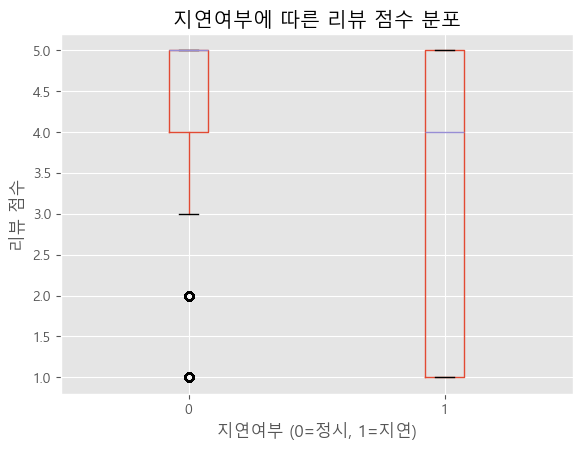

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='지연여부', y='review_score', data=df_review_merge, palette='pastel')


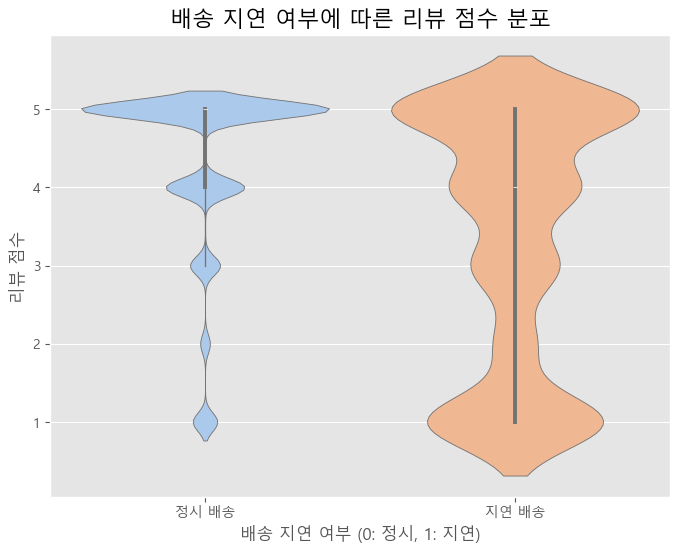

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='정시배송율', y='customer_city', data=top10, palette='viridis')


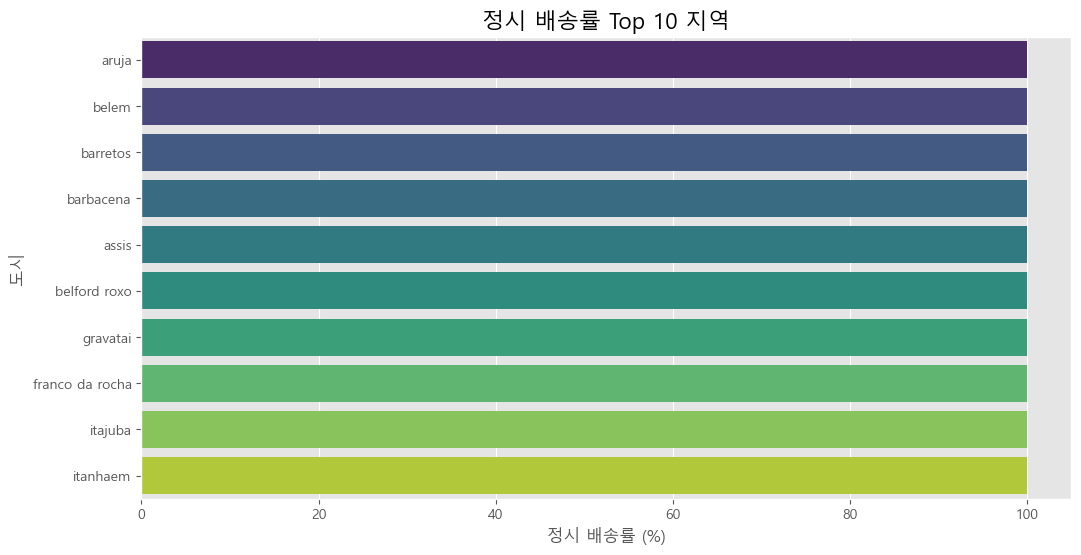

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='정시배송율', y='customer_city', data=bottom10, palette='plasma')


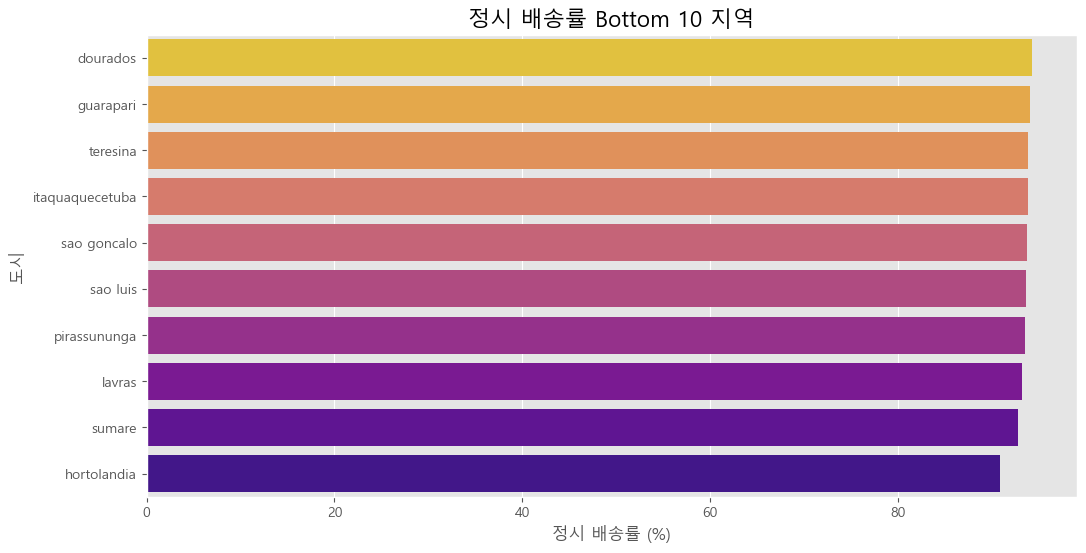

C:\Users\mumu1\AppData\Local\Temp\ipykernel_13152\3860234838.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='평균_전체배송', y='customer_city', data=bottom10, palette='magma')


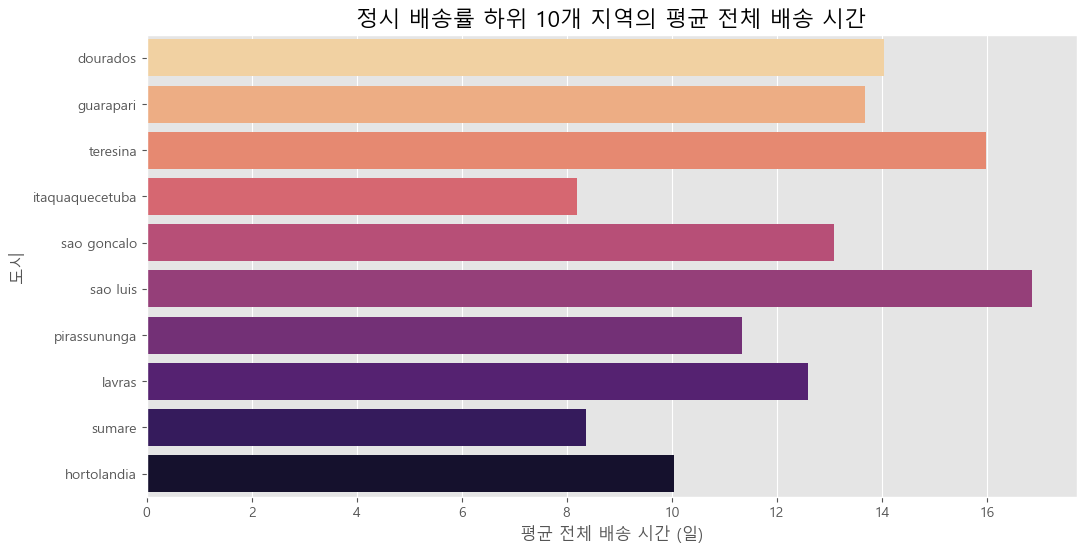

In [ ]:
plt.rc('font', family='Malgun Gothic') # 폰트 설정 (Mac: 'AppleGothic', Windows: 'Malgun Gothic')
plt.style.use('ggplot')

# 4. 시각화
df_review_merge.boxplot(column='review_score', by='지연여부')
plt.title("지연여부에 따른 리뷰 점수 분포")
plt.suptitle("")
plt.xlabel("지연여부 (0=정시, 1=지연)")
plt.ylabel("리뷰 점수")
plt.show()

# 지연 여부(0=정시, 1=지연)에 따른 리뷰 점수 분포 시각화
plt.figure(figsize=(8, 6))
sns.violinplot(x='지연여부', y='review_score', data=df_review_merge, palette='pastel')
plt.title('배송 지연 여부에 따른 리뷰 점수 분포', fontsize=16)
plt.xlabel('배송 지연 여부 (0: 정시, 1: 지연)', fontsize=12)
plt.ylabel('리뷰 점수', fontsize=12)
plt.xticks([0, 1], ['정시 배송', '지연 배송'])
plt.show()

# 정시배송율 Top 10 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='정시배송율', y='customer_city', data=top10, palette='viridis')
plt.title('정시 배송률 Top 10 지역', fontsize=16)
plt.xlabel('정시 배송률 (%)', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.show()

# 정시배송율 Bottom 10 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='정시배송율', y='customer_city', data=bottom10, palette='plasma')
plt.title('정시 배송률 Bottom 10 지역', fontsize=16)
plt.xlabel('정시 배송률 (%)', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.gca().invert_yaxis() # y축 순서 뒤집기
plt.show()

# 지역별 평균 전체 배송 시간 시각화 (정시배송률 하위 10개 지역)
plt.figure(figsize=(12, 6))
sns.barplot(x='평균_전체배송', y='customer_city', data=bottom10, palette='magma')
plt.title('정시 배송률 하위 10개 지역의 평균 전체 배송 시간', fontsize=16)
plt.xlabel('평균 전체 배송 시간 (일)', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.gca().invert_yaxis()
plt.show()